# Project Proposal

### Introduction

Tennis is a racket sport that is reliant on different shot techniques in their repertoire (i.e. forehand, backhand). It can be played in a singles or doubles match, wherein a player wins a match by winning two/three sets in a best-of-three/best-of-five match. A set is won by winning at least six games and two games more than the opponent, and every game is won by winning a total for at least four points and their score is two points more than the opponent.

Officially, players are assigned an Elo rating according to the Universal Tennis Rating (UTR) system, which rates players according to head-to-head results, independent of their age or nationality. The UTR system factors in the opponent that a player competed against as well as the set scores in the matches. As it is used on a global scale, the UTR can be used to match players with similar Elo ratings and therefore similar ability. This system, which is not only used globally and makes the matches more competitive, is recognized to be a helpful tool for player development and evaluator of rating tennis skill.

As such, in this project, we seek to assess the possible factors that also contribute to tennis players' current Elo ratings. We will be observing the experience (# of years played in Tennis) and hand techniques (backhand, dominant hand) to see if experience is more impactful than technique which would reflect in their current Elo rating/ranking. 

To help answer these questions, the dataset that will be used is the Player Stats for Top 500 Players dataset from https://www.ultimatetennisstatistics.com/. This dataset uses a similar system to the UTR, but with an optimized new K-factor function which allows for more stabilized ratings and player rankings.

In [1]:
# Loading Libraries, Remember to run this cell!
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

### Data Analysis

In [23]:
# Loading in the data
# Data read from https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS
player_stats <- read_csv("player_stats.csv")
colnames(player_stats) <- make.names(colnames(player_stats))
#   Remove unnecessary columns
player_stats <- player_stats %>%
    select(Age:Peak.Elo.Rating, Retired, -Country, -Wikipedia, -Current.Rank,-Name, -Seasons, -Prize.Money, -Active, -Favorite.Surface, -Best.Elo.Rank) %>%
#   Mutating columns with as_factor()
    mutate(Plays = as_factor(Plays)) %>%
    mutate(Backhand = as_factor(Backhand)) %>%
#   Cleaning up columns with string values
    mutate(Height = strtoi(str_remove(Height, " cm"))) %>%
    mutate(Year.Experience = 2020 - Turned.Pro) %>%
    mutate(Age = strtoi(substr(Age, 0, 2))) %>%
    mutate(Current.Elo.Rank = strtoi(substr(Current.Elo.Rank, 0, nchar(Current.Elo.Rank)-7))) %>%
    filter(!is.na(Turned.Pro)) %>%
    filter(is.na(Retired))

player_stats

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



Age,Plays,Best.Rank,Backhand,Height,Turned.Pro,Current.Elo.Rank,Peak.Elo.Rating,Retired,Year.Experience
<int>,<fct>,<chr>,<fct>,<int>,<dbl>,<int>,<chr>,<dbl>,<dbl>
32,Right-handed,44 (14-01-2013),Two-handed,185,2005,144,1886 (06-02-2012),NA,15
27,Right-handed,17 (11-01-2016),Two-handed,193,2008,100,2037 (01-02-2016),NA,12
22,Right-handed,31 (20-01-2020),Two-handed,NA,2015,33,1983 (20-01-2020),NA,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,Right-handed,74 (19-02-2018),Two-handed,NA,2008,143,1904 (12-02-2018),NA,12
26,Right-handed,249 (24-12-2018),Two-handed,NA,2009,180,1679 (10-01-2020),NA,11
26,Right-handed,4 (06-11-2017),One-handed,185,2011,6,2211 (18-11-2019),NA,9


### Methods

* If we use all variable to fit a mode, we will face 2 problems. The first problem is that the model might become too complex. The second problem is that the model might become overfitting that the model will lose the prediction power. The overfitting problem comes from the model is influenced by each data too much.

* We firstly select the variables by removing variables with subjectively less correlations which is done in the data analysis. Then we did the variable selection again as the variable is still too much which will make the model complex. We did three mthods here which is exhaustive,forward and backlward selection. It can show the which variable is needed to be included for best 3 variable model(current_rank,Peak.Elo.Rating,Age).

* We will visualize the results through analyzing the distributions from the scatter plots by using each exploratory variable and response variable. Then we compare it and our final predictions to see how good our model is.

Warning message:
“Removed 46 rows containing missing values (geom_point).”
Warning message:
“Removed 47 rows containing missing values (geom_point).”


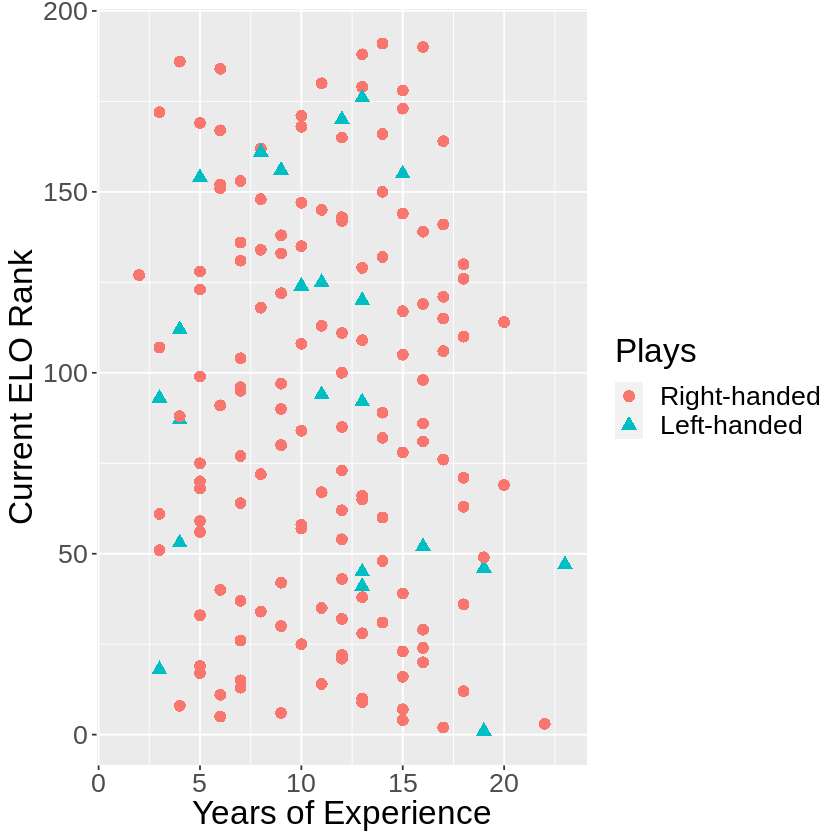

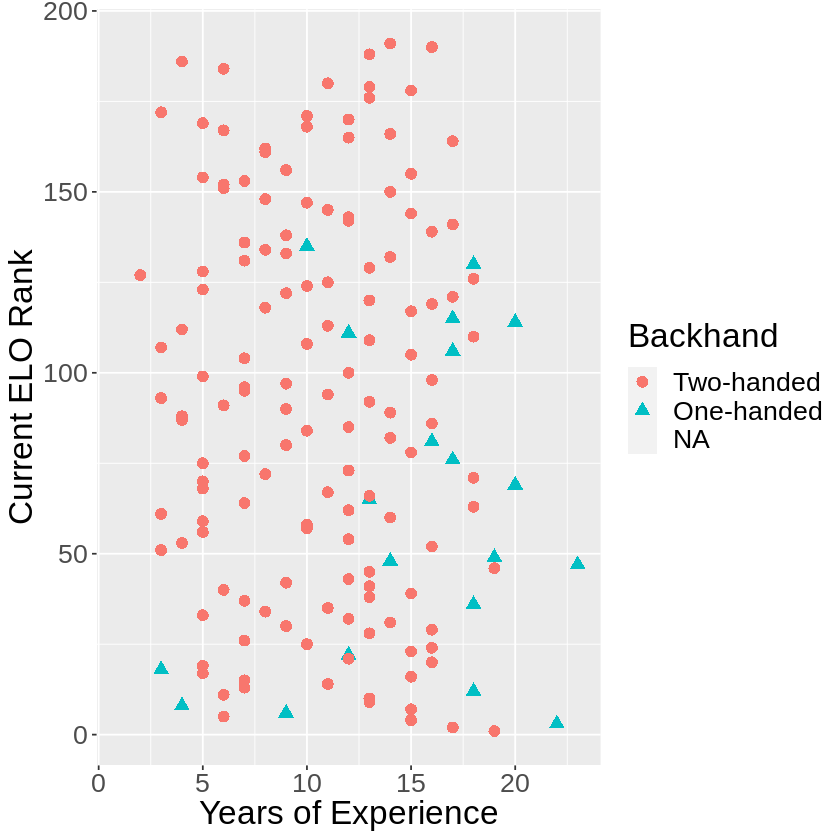

In [34]:
# df2<-separate(player_stats,Best.Rank,sep=" ",into=c("best_rank","time"))%>%
#      separate(Current.Elo.Rank,sep=" ",into=c("current_rank","current_time"))%>%
#      separate(Peak.Elo.Rating,sep=" ",into = c("Peak.Elo.Rating","timing"))%>%
#      select(-time,-current_time,-timing)%>%mutate(best_rank=as.numeric(best_rank))%>%
#      mutate(current_rank=as.numeric(current_rank))%>%mutate(Peak.Elo.Rating=as.numeric(Peak.Elo.Rating))


# head(df2)

# install.packages("leaps")
# library(leaps)
# rgs1 <- regsubsets(best_rank~Age+Plays+Backhand+Height+Turned.Pro+current_rank+Peak.Elo.Rating, data=df2, method="exhaustive") 
# srgs1 <- summary(rgs1)

# rgs2 <- regsubsets(best_rank~Age+Plays+Backhand+Height+Turned.Pro+current_rank+Peak.Elo.Rating, data=df2, method="forward") 
# srgs2 <- summary(rgs2)

# rgs3 <- regsubsets(best_rank~Age+Plays+Backhand+Height+Turned.Pro+current_rank+Peak.Elo.Rating, data=df2,method="backward") 
# srgs3 <- summary(rgs3)


# srgs1
# srgs2
# srgs3

# summary(lm(best_rank~Age+Plays+Backhand+Height+Turned.Pro+current_rank+Peak.Elo.Rating,data=df2))

plays_plot <- player_stats %>%
    ggplot(aes(x = Year.Experience, y = Current.Elo.Rank)) +
        geom_point(aes(colour = Plays, shape = Plays), size = 3) +
        labs(x = "Years of Experience", y = "Current ELO Rank") +
        theme(text = element_text(size = 20))
plays_plot

backhand_plot <- player_stats %>%
    ggplot(aes(x = Year.Experience, y = Current.Elo.Rank)) +
        geom_point(aes(colour = Backhand, shape = Backhand), size = 3) +
        labs(x = "Years of Experience", y = "Current ELO Rank") +
        theme(text = element_text(size = 20))
backhand_plot

### Expected Outcomes and Significance

From our data analysis, we compared the players’ techniques as well as experience. We expect to find that experience will outweigh the technique they use and would therefore impact their ranking more. The reason behind our hypothesis is simply because with enough practice, even if a technique may be less efficient, the player is more successful in terms of current ranking. However, our findings may show which techniques are superior, and would allow for the use of one technique to outperform someone with equal experience. This may prove a significance in that it shows what hand techniques that top-ranked players use to have a higher chance of defeating their opponents.